In [1]:
import joblib
import numpy as np
import os
import jax
from pathlib import Path
import mujoco

from traj_opt_helper import TrajectoryOptimizer
from algorithm import create_algorithm
from task import create_task

xla_flags = os.environ.get("XLA_FLAGS", "")
xla_flags += " --xla_gpu_triton_gemm_any=True"
xla_flags += " --xla_gpu_deterministic_ops=true"

os.environ["XLA_FLAGS"] = xla_flags

print(jax.devices()) 

/home/rooh/miniconda3/envs/benchmark/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[CudaDevice(id=0)]


## Trajectory Optimization Benchmarks

This notebook helps you run trajectory-optimization benchmarks on a robotics problem and visualize the solution.


**Supported sampling-based algorithms:**
- MPPI  
- MPPI-CMA  
- MPPI-CMA Block Diagonal
- Predictive Sampling  
- CMA-ES  
- Randomized Smoothing  
- Various Evolution strategies through Evosax

**Supported tasks:**

*Easy tasks*:
- Cartpole  
- Inverted Pendulum  
- Double Cartpole

*Hard tasks (contact-rich)*:
- PushT  
- Humanoid   


# Define you algorithm, task, and parameters

In [2]:

# algorithms = ["MPPI", "MPPI lr=0.1", "MPPI_CMA lr=(1.0, 0.1)", "MPPI_CMA lr=(0.1, 0.1)", "MPPI_CMA_BD lr=(1.0, 0.1)", "MPPI_CMA_BD lr=(0.1, 0.1)", "PredictiveSampling", "RandomizedSmoothing lr=0.1", "CMA-ES",] # ["MPPI",  "MPPI_CMA lr=(1.0, 0.1)", "PredictiveSampling", "RandomizedSmoothing lr=0.1"]
algorithms = ["MPPI",  "MPPI_CMA lr=(1.0, 0.1)", "PredictiveSampling", "RandomizedSmoothing lr=0.1"]
task_name = "HumanoidBalance" # "CartPole", "InvertedPendulum", "DoubleCartPole", "PushT", "HumanoidBalance", "HumanoidStandup"

# Experimental parameters:
num_trails = 6 # 6
max_iterations = 100
num_samples = 2048 # 2048
sigma_init = 0.3 # 0.3
temperature = 0.1
horizon = 1.0 # Suggested horizon: 1.0 (for humanoid); 2.0 (for others)

# Set this to (horizon/mj_model.opt.timestep) equals to no spline interpolation
num_knots = 8 # Suggested num_knots: 200 (for easy tasks: no interpolation);  20 for PushT, and 8 for Humanoid
spline = "zero" # "zero", "linear", "cubic"
run_benchmark = False # running benchmarks or not


# Load task (add your own task in task.py)

In [3]:
task, mj_model, mj_data = create_task(task_name=task_name)
# Python
if task.model.opt.disableflags & mujoco.mjtDisableBit.mjDSBL_WARMSTART:
    print("Warmstart is DISABLED")
else:
    print("Warmstart is ENABLED")

2025-06-18 19:33:28.551956: W external/xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.9.86. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


starting frame:200
Warmstart is DISABLED


# (Optionally) time the algorithms

In [4]:
# from profiler import time_profile, plot_results, time_components, plot_components

# algorithm_names = ["MPPI", "MPPI_CMA lr=(1.0, 0.1)", "MPPI_CMA_BD lr=(1.0, 0.1)", "PredictiveSampling"]
# task_names = ["CartPole", "PushT", "DoubleCartPole", "Humanoid"]

# # Profile multiple controllers
# results = []
# components = []
# for algorithm_name in algorithm_names:
#     for task_name in task_names:
#         task, mj_model_profile, mj_data_profile = create_task(task_name)
#         controller = create_algorithm(name = algorithm_name,
#                                 task = task,
#                                 num_samples = 2048,
#                                 horizon = 1.0,
#                                 num_knots = 25,
#                                 spline = "zero",
#                                 temperature = 1,
#                                 noise = 0.3)
#         component = time_components(controller, mj_model_profile, mj_data_profile)
#         components.append(component)
#         result = time_profile(controller, mj_model_profile, mj_data_profile)
#         results.append(result)

# # # Plot all results
# plot_results(results)
# plot_components(components)

# Run benchmarks
* The control trajectory of the best solution will be plotted

In [5]:
if run_benchmark == True:
    for algorithm in algorithms:

        alg = create_algorithm(name = algorithm, 
                            task = task,
                            num_samples = num_samples,
                            horizon = horizon,
                            num_knots = num_knots,
                            spline = spline,
                            temperature = temperature,
                            noise = sigma_init)

        to = TrajectoryOptimizer(algorithm, alg, mj_model, mj_data)
        to.trails(max_iteration=max_iterations, num_trails = num_trails, save_npz=True)
else:
    alg = create_algorithm(name = "visualization", 
                            task = task,
                            num_samples = num_samples,
                            horizon = horizon,
                            num_knots = num_knots,
                            spline = spline,
                            temperature = temperature,
                            noise = sigma_init)

    to = TrajectoryOptimizer("visualization", alg, mj_model, mj_data)

Trajectory Optimization with 8 steps over a 1.0 second horizon.
task.dt:0.02; controller.dt:0.02; task.model.opt.timestep: 0.02; task.mj_model.opt.timestep: 0.02; simulator mj_model.opt.timestep: 0.02


# Generate convergence plot

┌──────────────────────────────────────────────┐
│ Visualising results…                        │
└──────────────────────────────────────────────┘
Figure saved to: /home/rooh/workspace/rs-rl/traj_opt/figures/HumanoidMocap/HumanoidMocap_Convergence.pdf


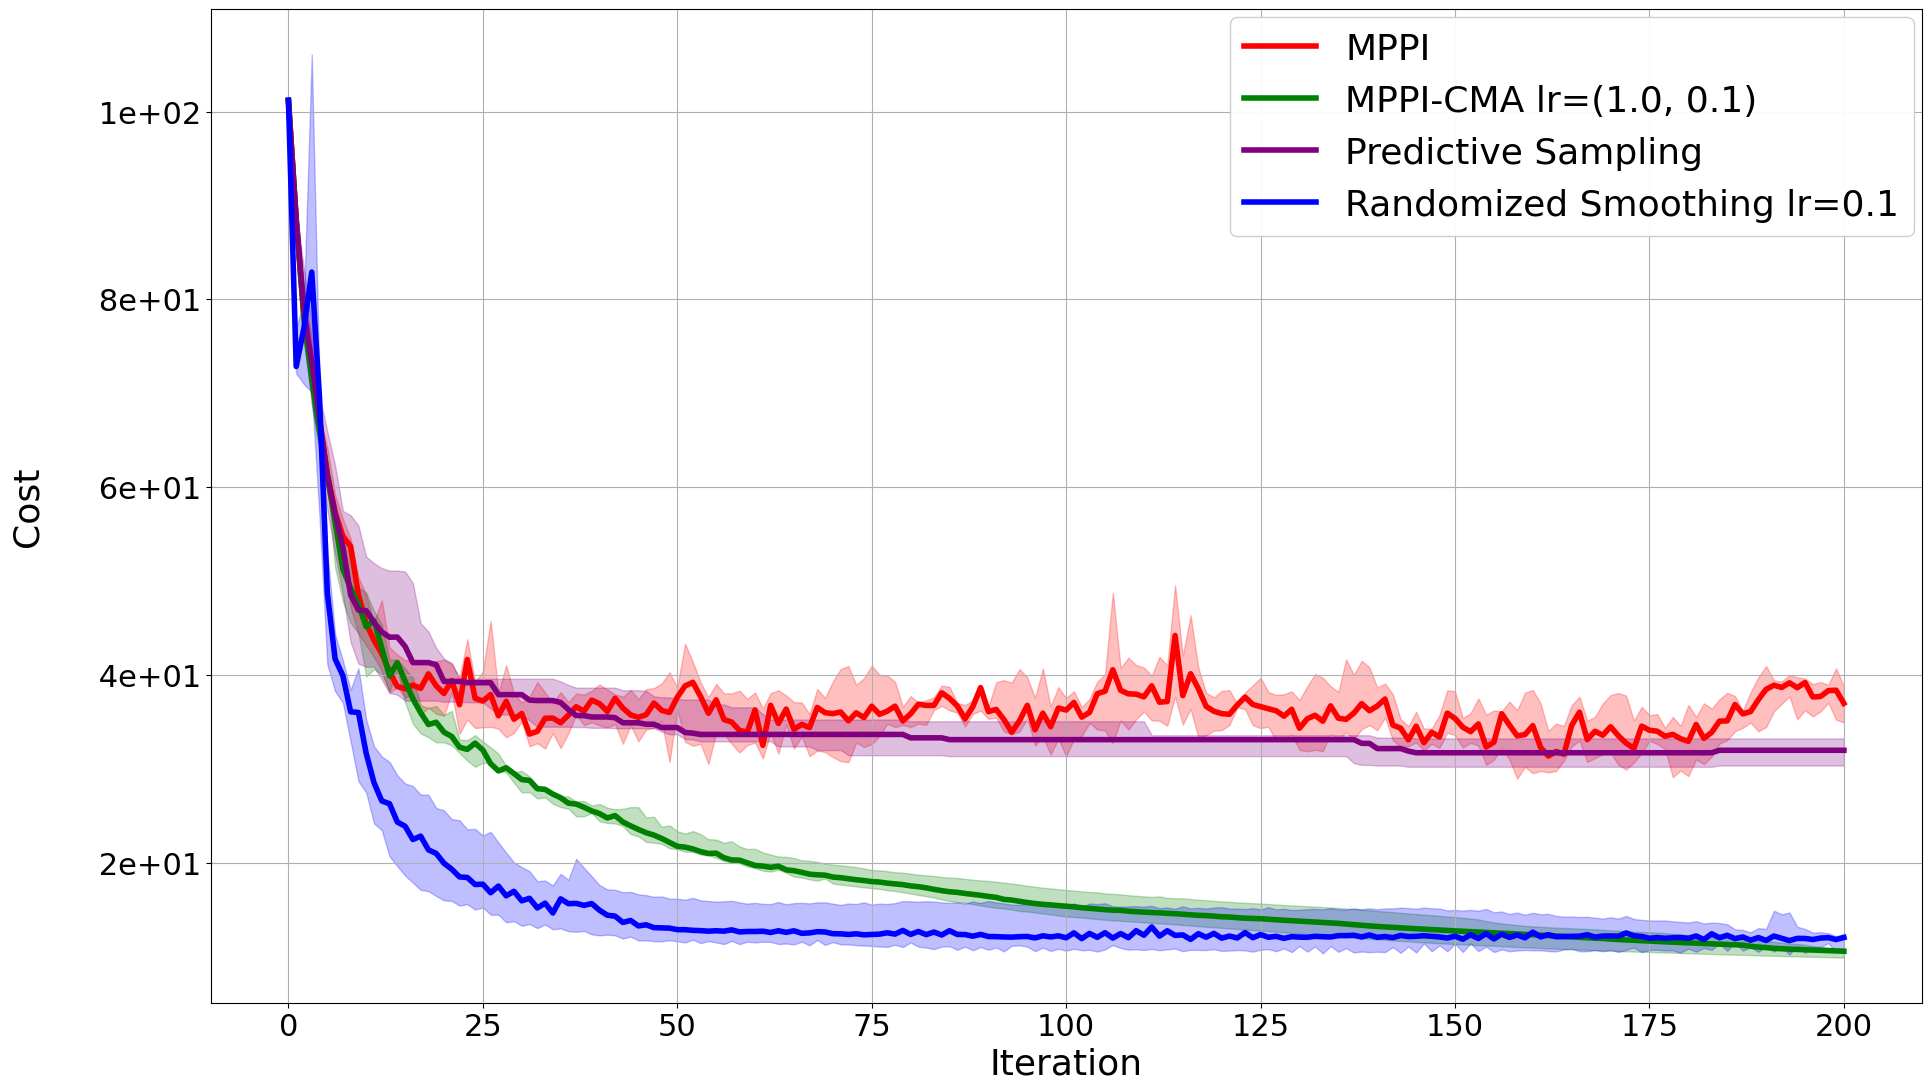

In [6]:
from plot import visualize_optimization_results

details = visualize_optimization_results(task, algorithms)

# Visualize solutions

In [ ]:
to.visualize_rollout_gif(task, "MPPI_CMA lr=(1.0, 0.1)", fps=30, show_reference=True)

In [ ]:
to.visualize_rollout_gif(task, "MPPI", fps=30, show_reference=True)


GIF saved to: /home/rooh/workspace/rs-rl/traj_opt/figures/HumanoidMocap/MPPI_CMA_BD lr=(1.0, 0.1).gif


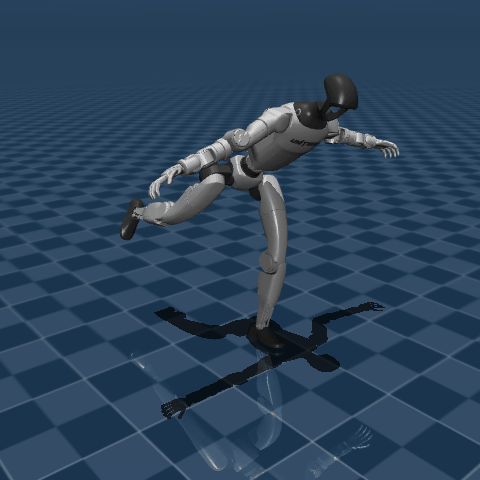

In [ ]:
to.visualize_rollout_gif(task, "MPPI_CMA_BD lr=(1.0, 0.1)", fps=30, show_reference=True)
